## Data handling

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DATA_DIR = r'C:\Users\suman\Downloads\ai suman\Dataset Part 2\data'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32


def load_images_and_labels(data_dir, image_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    print(f"Detected classes: {class_names}")
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            print(f"Loading images from: {class_dir}")
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = load_img(img_path, target_size=image_size)
                        img_array = img_to_array(img)
                        images.append(img_array)
                        labels.append(class_names.index(class_name))
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")

    images = np.array(images, dtype="float32")
    labels = np.array(labels)
    return images, labels, class_names


print("Loading dataset...")
images, labels, class_names = load_images_and_labels(DATA_DIR, IMAGE_SIZE)

print(f"Loaded dataset: {images.shape}, Labels: {labels.shape}")
print(f"Classes: {class_names}")

images = images / 255.0
print("Images normalized to [0, 1].")

X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

y_train_one_hot = to_categorical(y_train, num_classes=len(class_names))
y_val_one_hot = to_categorical(y_val, num_classes=len(class_names))
y_test_one_hot = to_categorical(y_test, num_classes=len(class_names))

print(f"Training labels shape (one-hot): {y_train_one_hot.shape}")
print(f"Validation labels shape (one-hot): {y_val_one_hot.shape}")
print(f"Test labels shape (one-hot): {y_test_one_hot.shape}")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

Loading dataset...
Detected classes: ['with_mask', 'without_mask']
Loading images from: C:\Users\suman\Downloads\ai suman\Dataset Part 2\data\with_mask


C:\Users\suman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loading images from: C:\Users\suman\Downloads\ai suman\Dataset Part 2\data\without_mask
Loaded dataset: (7553, 128, 128, 3), Labels: (7553,)
Classes: ['with_mask', 'without_mask']
Images normalized to [0, 1].
Training set size: 5287
Validation set size: 1133
Test set size: 1133
Training labels shape (one-hot): (5287, 2)
Validation labels shape (one-hot): (1133, 2)
Test labels shape (one-hot): (1133, 2)


## Model building


In [10]:
def build_cnn_classifier(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = X_train.shape[1:]   
num_classes = len(class_names)    

# CNN model build
cnn_model = build_cnn_classifier(input_shape, num_classes)

# Compile CNN
loss_function = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'
cnn_model.compile(optimizer='adam',
                  loss=loss_function,
                  metrics=['accuracy'])
cnn_model.summary()
print("\n Setting up YOLOv5 Object Detection model...")
try:
    from ultralytics import YOLO
    yolo_model = YOLO('yolov5s.pt')  
    print("YOLOv5s model loaded successfully.")
except Exception as e:
    print(f"⚠ Error loading YOLOv5 model: {e}")
    yolo_model = None
print("\nModel building complete (CNN + YOLO).")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


 Setting up YOLOv5 Object Detection model...
PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv5s model loaded successfully.

Model building complete (CNN + YOLO).


In [11]:
import ultralytics 
try:
    yolo_model = ultralytics.YOLO('yolov5s.pt') 

except Exception as e:
    print(f"Error loading YOLOv5 model: {e}")
    print("Please ensure you have an internet connection to download the weights.")
    yolo_model = None

print("Data preparation for YOLOv5 training (images and normalized bounding box labels in TXT format) will be required before training.")

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Data preparation for YOLOv5 training (images and normalized bounding box labels in TXT format) will be required before training.


## Model Training


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.keras', 
    monitor='val_loss',    
    save_best_only=True,    
    mode='min',             
    verbose=1               
)

if 'cnn_model' not in locals():
    print("CNN model not found. Please ensure the 'cnn_model' variable is defined.")
else:

    print("Starting CNN model training...")

    cnn_history = cnn_model.fit(
        datagen.flow(X_train, y_train_one_hot, batch_size=BATCH_SIZE),
        epochs=50, 
        validation_data=(X_val, y_val_one_hot),
        callbacks=[early_stopping, model_checkpoint]
    )
    print("CNN model training complete.")

Starting CNN model training...
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9675 - loss: 0.0929
Epoch 1: val_loss improved from None to 0.06856, saving model to best_cnn_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9639 - loss: 0.1029 - val_accuracy: 0.9788 - val_loss: 0.0686
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9707 - loss: 0.0870
Epoch 2: val_loss improved from 0.06856 to 0.06261, saving model to best_cnn_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9692 - loss: 0.0908 - val_accuracy: 0.9762 - val_loss: 0.0626
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9697 - loss: 0.0874
Epoch 3: val_loss improved from 0.06261 to 0.04970, saving model to best_cnn_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 154ms/step - accuracy: 0.9695 - loss: 0.0907 - val_accuracy: 0.9859 - val_loss: 0.0497
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9697 - loss: 

## Model Evaluation


Best CNN model loaded successfully.
Evaluating CNN model on test data...
🔹 Test Loss: 0.0888
🔹 Test Accuracy: 0.9744
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

📊 CNN Classification Metrics:
Accuracy  : 0.9744
Precision : 0.9806
Recall    : 0.9686
F1-score  : 0.9746


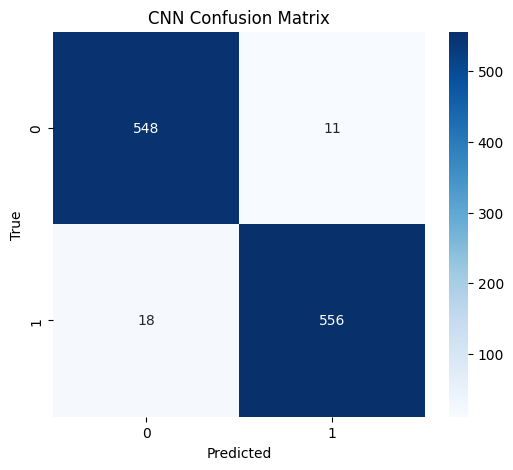

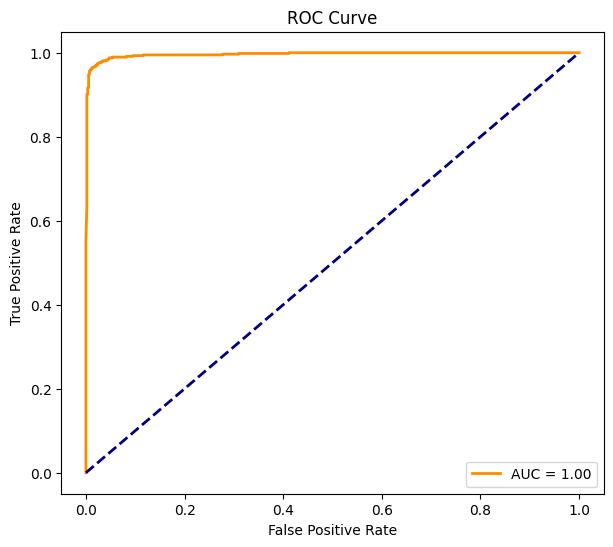

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
)
import tensorflow as tf

try:
    best_cnn_model = tf.keras.models.load_model('best_cnn_model.keras')
    print("Best CNN model loaded successfully.")
except Exception as e:
    print(f"Error loading best CNN model: {e}")
    best_cnn_model = None

if best_cnn_model:
    if 'X_test' in locals() and 'y_test_one_hot' in locals():
        print("Evaluating CNN model on test data...")
        loss, accuracy = best_cnn_model.evaluate(X_test, y_test_one_hot, verbose=0)
        print(f"🔹 Test Loss: {loss:.4f}")
        print(f"🔹 Test Accuracy: {accuracy:.4f}")
        
        y_pred_prob = best_cnn_model.predict(X_test)
        if 'y_test' not in locals():
            y_test = np.argmax(y_test_one_hot, axis=1)  
        y_pred = np.argmax(y_pred_prob, axis=1) if y_pred_prob.shape[1] > 1 else (y_pred_prob > 0.5).astype(int).flatten()

        cnn_accuracy = accuracy_score(y_test, y_pred)
        cnn_precision = precision_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'macro')
        cnn_recall = recall_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'macro')
        cnn_f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'macro')

        print("\n CNN Classification Metrics:")
        print(f"Accuracy  : {cnn_accuracy:.4f}")
        print(f"Precision : {cnn_precision:.4f}")
        print(f"Recall    : {cnn_recall:.4f}")
        print(f"F1-score  : {cnn_f1:.4f}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("CNN Confusion Matrix")
        plt.show()

        if y_pred_prob.shape[1] == 1 or y_pred_prob.shape[1] == 2:
            y_pred_prob_positive = y_pred_prob[:,1] if y_pred_prob.ndim > 1 else y_pred_prob.flatten()
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob_positive)
            roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

            plt.figure(figsize=(7,6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
            plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend(loc="lower right")
            plt.show()
        else:
            print("ROC curve skipped (not binary classification).")
    else:
     print("Model not loaded.")

## Visualizations


🔍 Testing on image: C:/Users/suman/Downloads/ai suman/Dataset Part 2/data/without_mask\without_mask_92.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
✅ CNN Prediction: with_mask (1.00)

image 1/1 C:\Users\suman\Downloads\ai suman\Dataset Part 2\data\without_mask\without_mask_92.jpg: 640x640 1 person, 1 cat, 156.9ms
Speed: 2.1ms preprocess, 156.9ms inference, 12.7ms postprocess per image at shape (1, 3, 640, 640)
YOLO prediction complete.


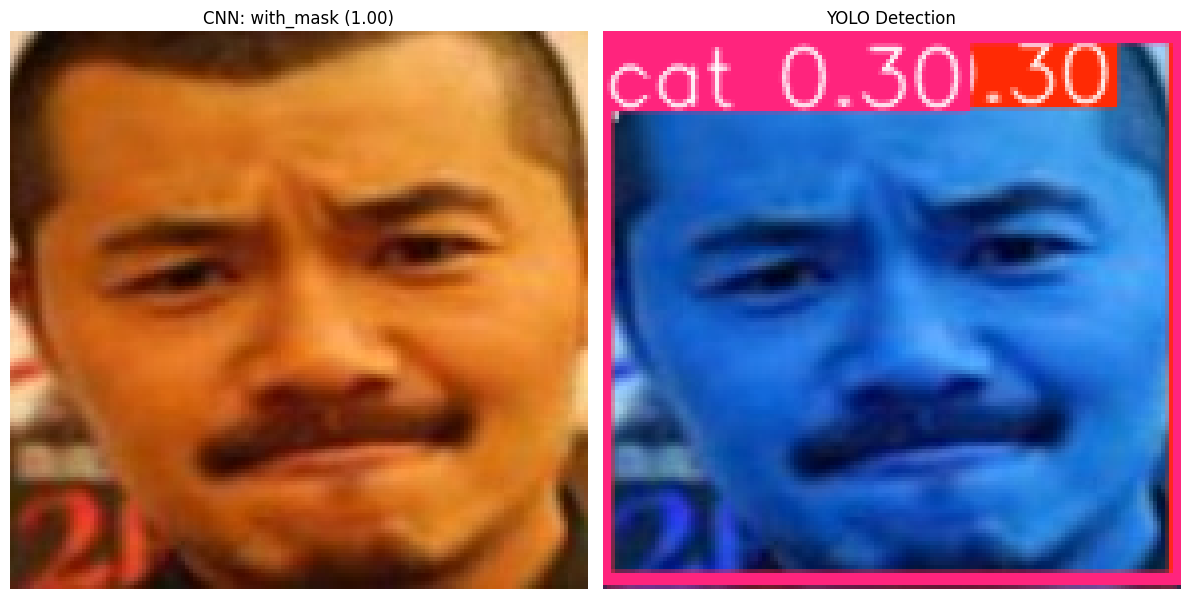

In [27]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

dataset_folder = r"C:/Users/suman/Downloads/ai suman/Dataset Part 2/data/without_mask"
all_images = [f for f in os.listdir(dataset_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if len(all_images) == 0:
    print("⚠ Dataset folder not found")
else:
    random_image = random.choice(all_images)
    test_image_path = os.path.join(dataset_folder, random_image)
    print(f"🔍 Testing on image: {test_image_path}")

    cnn_pred_label = None
    cnn_conf = None
    cnn_display_img = None

    if 'cnn_model' in locals() and cnn_model is not None:
        try:
            img = cv2.imread(test_image_path)
            img_resized = cv2.resize(img, (128, 128)) / 255.0  
            input_data = np.expand_dims(img_resized, axis=0)

            prediction = cnn_model.predict(input_data)
            class_index = np.argmax(prediction)
            cnn_conf = np.max(prediction)

            class_labels = ["with_mask", "without_mask"]
            cnn_pred_label = class_labels[class_index]
            cnn_display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            print(f"✅ CNN Prediction: {cnn_pred_label} ({cnn_conf:.2f})")
        except Exception as e:
            print(f"⚠ Error running CNN visualization: {e}")

    yolo_display_img = None
    if 'yolo_model' in locals() and yolo_model is not None:
        try:
            results = yolo_model.predict(source=test_image_path, save=False)
            result = results[0]  
            yolo_display_img = result.plot()  
            print("YOLO prediction complete.")
        except Exception as e:
            print(f"⚠ Error running YOLO visualization: {e}")

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    if cnn_display_img is not None:
        axs[0].imshow(cnn_display_img)
        axs[0].set_title(f"CNN: {cnn_pred_label} ({cnn_conf:.2f})", fontsize=12)
        axs[0].axis("off")

    if yolo_display_img is not None:
        axs[1].imshow(yolo_display_img)
        axs[1].set_title("YOLO Detection", fontsize=12)
        axs[1].axis("off")

    plt.tight_layout()
    plt.show()
